In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import warnings
warnings.filterwarnings("ignore")

### Image Restoration

#### Case 1

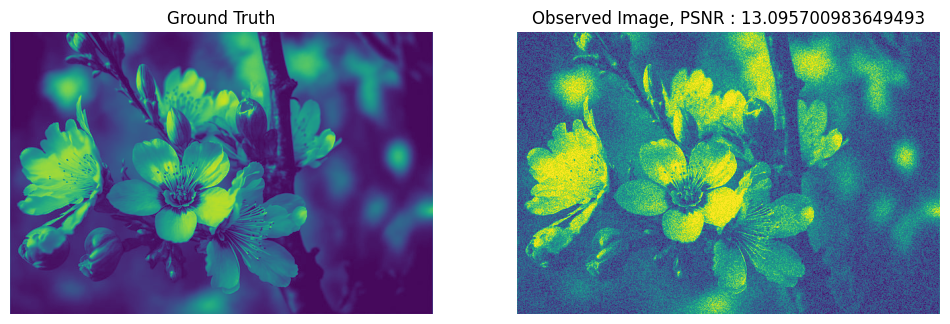

In [2]:
f_img = cv2.imread("Images/AI Flower.jpg", cv2.IMREAD_GRAYSCALE)

def add_uniform_noise(image, intensity=100):    
    noise = np.random.rand(*image.shape) * intensity
    return np.clip(noise + image, 0, 255).astype(np.uint8)

# g = Af + n
g_img = add_uniform_noise(f_img)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.axis('off')
plt.imshow(f_img)

plt.subplot(1, 2, 2)
plt.title("Observed Image, PSNR : {}".format(peak_signal_noise_ratio(f_img, g_img)))
plt.axis('off')
plt.imshow(g_img)

plt.show()

#### Wiener Filter 

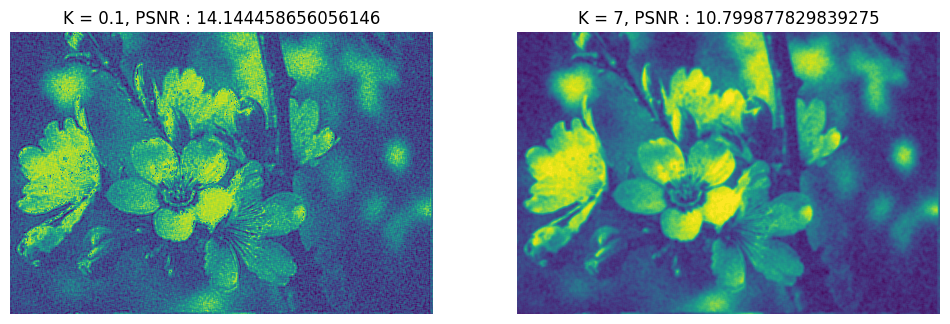

In [3]:
def wiener_filter(img, kernel, K):
    
    fft_img = np.fft.fft2(img)
    fft_kernel = np.fft.fft2(kernel, s=img.shape)
    
    fft_H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + K * np.ones(fft_kernel.shape))
    filtered_freq = fft_img * fft_H
    
    return np.abs(np.fft.ifft2(filtered_freq))
    
kernel = np.ones((5, 5)) / 25
f_estimate_1 = wiener_filter(g_img, kernel, 0.1).astype(np.uint8)
f_estimate_2 = wiener_filter(g_img, kernel, 7).astype(np.uint8)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("K = 0.1, PSNR : {}".format(peak_signal_noise_ratio(f_img, f_estimate_1)))
plt.axis('off')
plt.imshow(f_estimate_1)

plt.subplot(1, 2, 2)
plt.title("K = 7, PSNR : {}".format(peak_signal_noise_ratio(f_img, f_estimate_2)))
plt.axis('off')
plt.imshow(f_estimate_2)

plt.show()

#### MAP Estimation

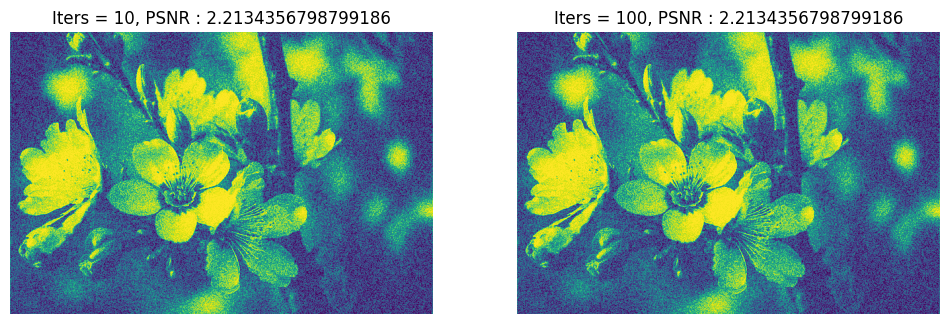

In [4]:
from scipy.signal import convolve2d

def map_restore(g_img, kernel, nlevel, iters):
    f_img = g_img.copy()

    for _ in range(iters):
        blur_estimate = convolve2d(f_img, kernel, mode='same', boundary='wrap')
        data_likelihood = np.exp(-0.5 * ((g_img - blur_estimate) / nlevel) ** 2)
        prior_likelihood = np.ones_like(f_img)  # Uniform prior
        posterior = data_likelihood * prior_likelihood
        f_img = posterior / np.sum(posterior)

    return 1 - f_img

kernel = np.ones((5, 5)) / 25
f_estimate_1 = map_restore(g_img, kernel, 100, 10)
f_estimate_2 = map_restore(g_img, kernel, 100, 100)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Iters = 10, PSNR : {}".format(peak_signal_noise_ratio(f_img/255, f_estimate_1)))
plt.axis('off')
plt.imshow(f_estimate_1)

plt.subplot(1, 2, 2)
plt.title("Iters = 100, PSNR : {}".format(peak_signal_noise_ratio(f_img/255, f_estimate_2)))
plt.axis('off')
plt.imshow(f_estimate_2)

plt.show()

#### Deep Network Based Approach

In [5]:
import replicate

f_img = cv2.imread("Images/AI Flower.jpg")
g_img = add_uniform_noise(f_img)

cv2.imwrite("Images/g_img_1.jpg", g_img)

api = replicate.Client(api_token = 'YOUR_API_KEY')
output = api.run(
    "megvii-research/nafnet:e116b6df8437d9c562f9de2a86cea6fd76a96705e502f091457926bbe989436c",
    input={
        "image": "https://raw.githubusercontent.com/Mr-Appu/College-Dump/main/Computer%20Vision/Assignments/Images/g_img_1.jpg",
        "task_type": "Image Denoising"
    }
)

print(output)

https://replicate.delivery/pbxt/jOyu7k9MFU6IOdQjZxelfjKwE65ujyQreR9noDqGpOWGKxElA/output.png


#### Case 2

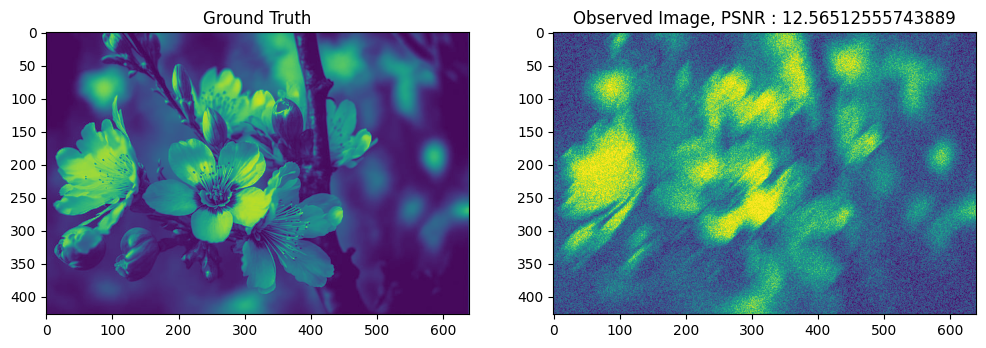

In [6]:
f_img = cv2.imread("Images/AI Flower.jpg", cv2.IMREAD_GRAYSCALE)

# n
def add_uniform_noise(image, intensity=100):    
    noise = np.random.rand(*image.shape) * intensity
    return np.clip(noise + image, 0, 255).astype(np.uint8)

# A
def kernel(n):
    A = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        A[i, n - i - 1] = 1
    A /= n
    return A

A = kernel(21)

# g = Af + n
g_img = add_uniform_noise(cv2.filter2D(f_img, -1, A))

# Plot 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(f_img)

plt.subplot(1, 2, 2)
plt.title("Observed Image, PSNR : {}".format(peak_signal_noise_ratio(f_img, g_img)))
plt.imshow(g_img)

plt.show()

#### Wiener Filter 

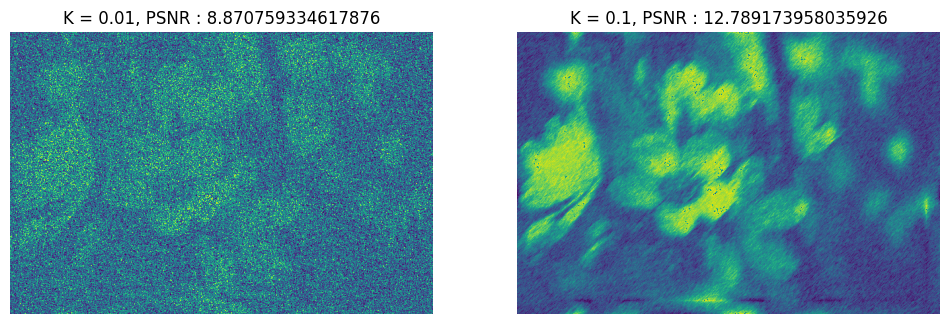

In [7]:
def wiener_filter(img, kernel, K):
    
    fft_img = np.fft.fft2(img)
    fft_kernel = np.fft.fft2(kernel, s=img.shape)
    
    fft_H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + K * np.ones(fft_kernel.shape))
    filtered_freq = fft_img * fft_H
    
    return np.abs(np.fft.ifft2(filtered_freq))

f_estimate_1 = wiener_filter(g_img, A, 0.01).astype(np.uint8)
f_estimate_2 = wiener_filter(g_img, A, 0.1).astype(np.uint8)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("K = 0.01, PSNR : {}".format(peak_signal_noise_ratio(f_img, f_estimate_1)))
plt.axis('off')
plt.imshow(f_estimate_1)

plt.subplot(1, 2, 2)
plt.title("K = 0.1, PSNR : {}".format(peak_signal_noise_ratio(f_img, f_estimate_2)))
plt.axis('off')
plt.imshow(f_estimate_2)

plt.show()

#### MAP Estimation

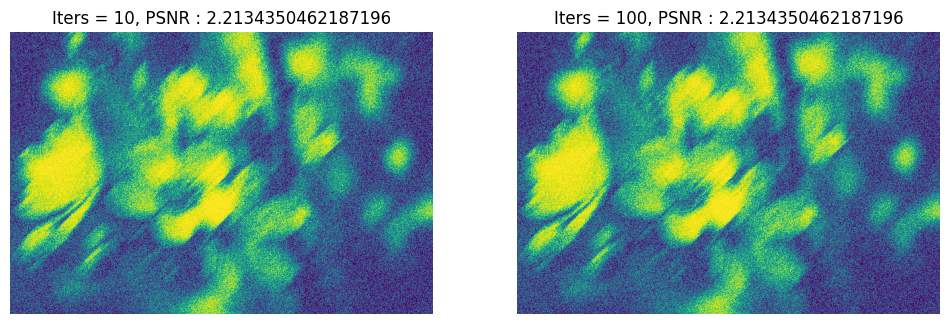

In [8]:
def map_restore(g_img, kernel, nlevel, iters):
    f_img = g_img.copy()

    for _ in range(iters):
        blur_estimate = convolve2d(f_img, kernel, mode='same', boundary='wrap')
        data_likelihood = np.exp(-0.5 * ((g_img - blur_estimate) / nlevel) ** 2)
        prior_likelihood = np.ones_like(f_img)  # Uniform prior
        posterior = data_likelihood * prior_likelihood
        f_img = posterior / np.sum(posterior)

    return 1 - f_img

f_estimate_1 = map_restore(g_img, A, 100, 10)
f_estimate_2 = map_restore(g_img, A, 100, 100)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Iters = 10, PSNR : {}".format(peak_signal_noise_ratio(f_img/255, f_estimate_1)))
plt.axis('off')
plt.imshow(f_estimate_1)

plt.subplot(1, 2, 2)
plt.title("Iters = 100, PSNR : {}".format(peak_signal_noise_ratio(f_img/255, f_estimate_2)))
plt.axis('off')
plt.imshow(f_estimate_2)

plt.show()

#### Deep Network Based Approach

In [9]:
import replicate

f_img = cv2.imread("Images/AI Flower.jpg")
g_img = add_uniform_noise(cv2.filter2D(f_img, -1, A))

cv2.imwrite("Images/g_img_2.jpg", g_img)

api = replicate.Client(api_token = 'YOUR_API_KEY')
output = api.run(
    "megvii-research/nafnet:e116b6df8437d9c562f9de2a86cea6fd76a96705e502f091457926bbe989436c",
    input={
        "image": "https://raw.githubusercontent.com/Mr-Appu/College-Dump/main/Computer%20Vision/Assignments/Images/g_img_2.jpg",
        "task_type": "Image Denoising"
    }
)

print(output)

https://replicate.delivery/pbxt/VmaPG2dsih5cDJ6CQ4j1qJsKCuOH82dKaxMpifYFbXVwSMRJA/output.png
